In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.synthetic_array_beamformer_processor import SyntheticArrayBeamformerProcessor
from mmwave_radar_processing.plotting.plotter_synthetic_array_data import PlotterSyntheticArrayData
from mmwave_radar_processing.plotting.movies_synthetic_array_data import MovieGeneratorSyntheticArrayData
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ImportError: cannot import name 'CaCFAR_2D' from 'mmwave_radar_processing.detectors.CFAR' (/home/david/Documents/mmwave_radar_processing/mmwave_radar_processing/detectors/CFAR.py)

In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
dataset_name = "RadSAR_2_CPSL"
dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

did not find radar samples
did not find lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples
did not find vehicle odometry samples


In [4]:
cfar_2d = CaCFAR_2D(
    num_guard_cells=np.array([2,5]),
    num_training_cells=np.array([3,15]),
    false_alarm_rate=0.001,
    resp_border_cells=np.array([5,5]),
    mode="full"
)

processor = SyntheticArrayBeamformerProcessor(
    config_manager=cfg_manager,
    cfar=cfar_2d,
    az_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-35,stop=35,num=80
                 )),
    el_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-60,
                    stop=60,
                    num=16
                ))
)

synthetic_array_plotter = PlotterSyntheticArrayData(
    config_manager=cfg_manager,
    synthetic_array_processor=processor,
    min_vel=0.4
)

movie_generator = MovieGeneratorSyntheticArrayData(
    cpsl_dataset=dataset,
    plotter=synthetic_array_plotter,
    processor=processor,
    temp_dir_path="~/Downloads/syntheticArrays"
)

alpha: 6.968355977686613 (mag), 16.86260656902793 dB


TypeError: PlotterSyntheticArrayData.__init__() got an unexpected keyword argument 'synthetic_array_processor'

In [ ]:
idx = 30
while np.abs(np.mean(dataset.get_vehicle_vel_data(idx)[:,1])) < 0.4:
    idx += 1
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])

processor._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
print(idx)

30


In [ ]:
#get the velocity of the vehicle
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])

#generate the array geometry
processor._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
#get the adc cube
adc_cube = dataset.get_radar_data(idx)
#compute the response
resp = processor.process(adc_cube)
dets = processor.beamformed_dets
#get the lidar pointcloud for gt comparison
lidar_pc_raw = dataset.get_lidar_point_cloud_raw(idx)

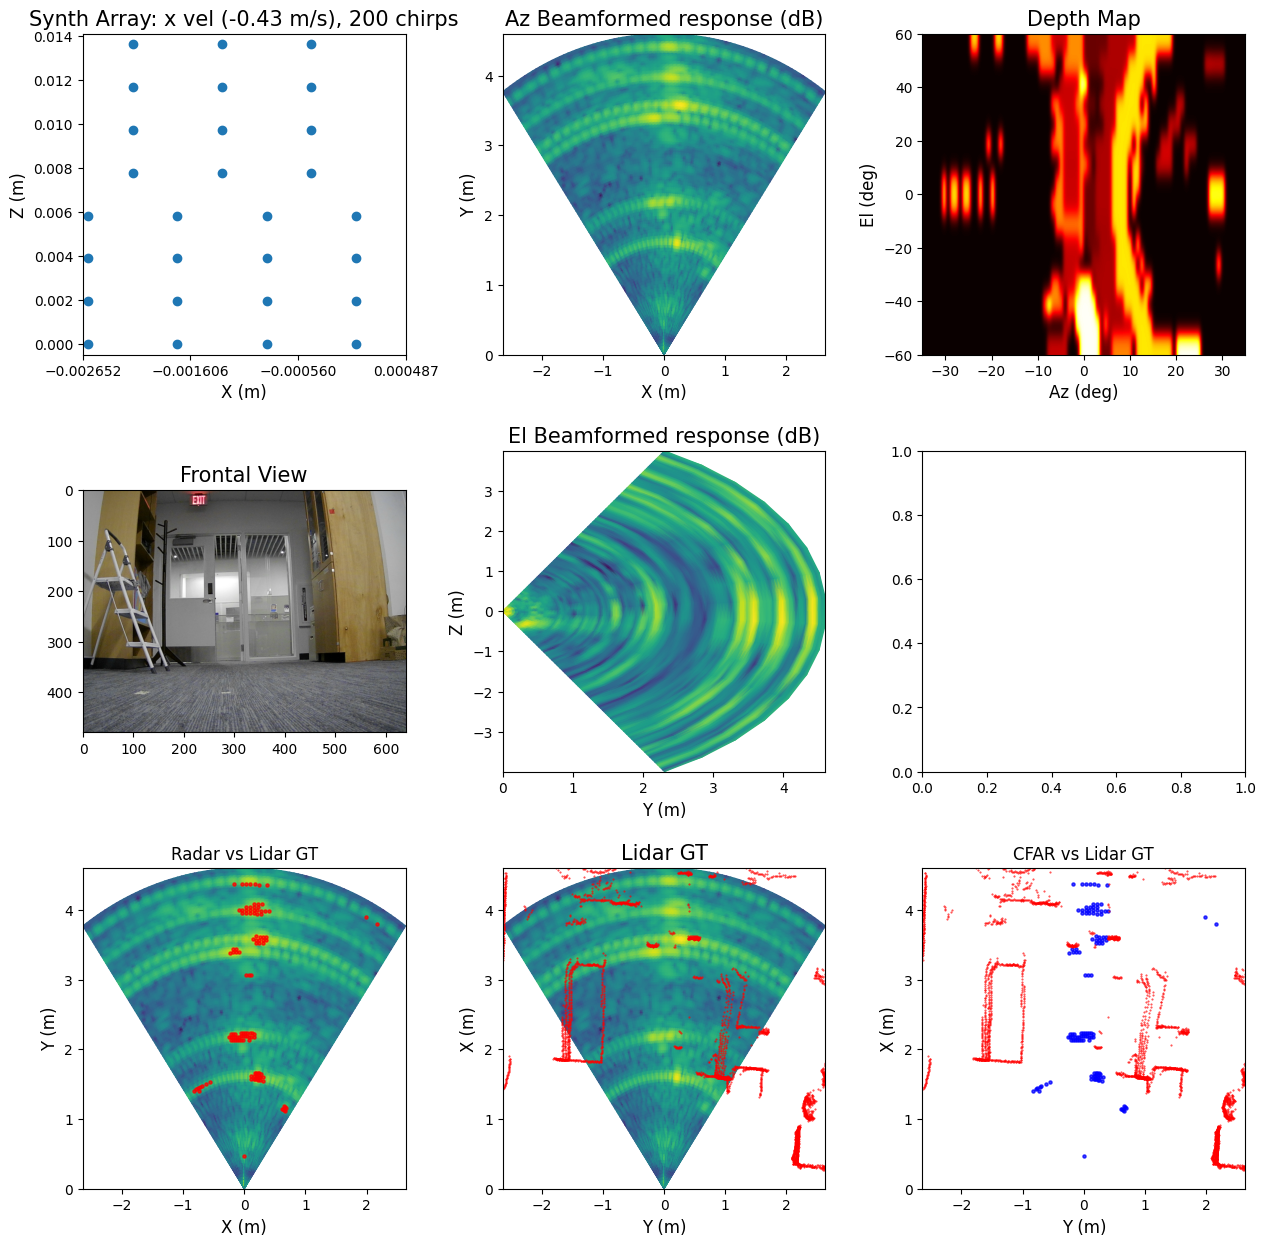

In [ ]:
synthetic_array_plotter.plot_compilation(
    adc_cube=adc_cube,
    vels=np.array([-vel,0,0]),
    camera_view=dataset.get_camera_frame(idx),
    lidar_pc_raw=lidar_pc_raw,
    lidar_radar_offset_rad=np.deg2rad(180),
    convert_to_dB=True,
    cmap="viridis",
    show=True
)

### Looking at the results for the original beamforming technique

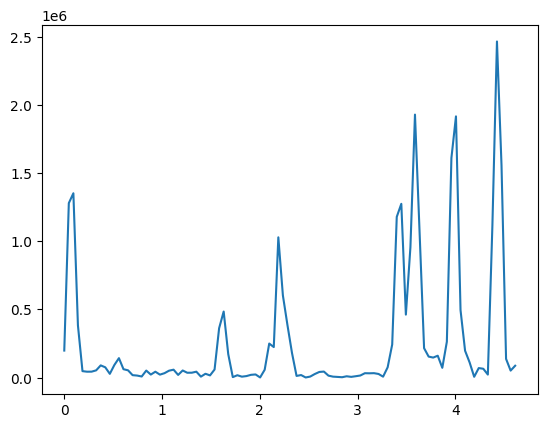

In [ ]:
#original beamforming method
az_idx = 40
el_idx = 8

#reshape the adc cube
adc_cube_reshaped = np.transpose(adc_cube,axes=(1,0,2))

#stearing vector
steering_vector = processor.d[:,az_idx,el_idx]

#reshape the adc cube further
adc_cube_reshaped = np.reshape(
        adc_cube_reshaped,
        (adc_cube_reshaped.shape[0],-1),
        order="F"
    )

#compute the phase shift to apply to each received signal
shifts = np.exp(
    1j * 2 * np.pi * \
    (steering_vector @ processor.p_reshaped) / processor.lambda_m)
shifts = np.reshape(shifts,(1,shifts.shape[0]))

#compute the beamformed response
beamformed_resps = np.multiply(adc_cube_reshaped,shifts)
beamformed_resp = np.sum(beamformed_resps,axis=1)

#compute the window
window = np.hanning(processor.num_range_bins)
beamformed_resp = np.fft.fft(window * beamformed_resp)
plt.plot(processor.range_bins,np.abs(beamformed_resp))

### Looking at the results for a modified beamforming technique

Text(0.5, 1.0, 'Phase shifts')

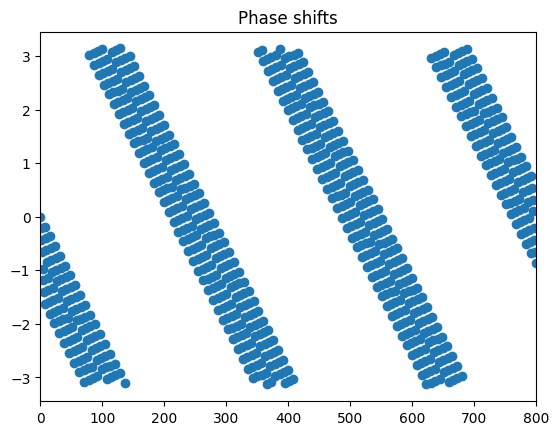

In [ ]:
az_idx = 48
el_idx = 7

#reshape the adc cube
adc_cube_reshaped = np.transpose(adc_cube,axes=(1,0,2))

#stearing vector
steering_vector = processor.d[:,az_idx,el_idx]

#reshape the adc cube further
adc_cube_reshaped = np.reshape(
        adc_cube_reshaped,
        (adc_cube_reshaped.shape[0],-1),
        order="F"
    )

#compute the phase shift to apply to each received signal

shifts = np.exp(
    1j * 2 * np.pi * \
    (steering_vector @ processor.p_reshaped) / processor.lambda_m)
shifts = np.reshape(shifts,(1,shifts.shape[0]))

plt.plot(np.angle(shifts[0,:]),"o")
_ = plt.xlim((0,800))
plt.title("Phase shifts")


Text(0.5, 1.0, 'responses before shifting (mag)')

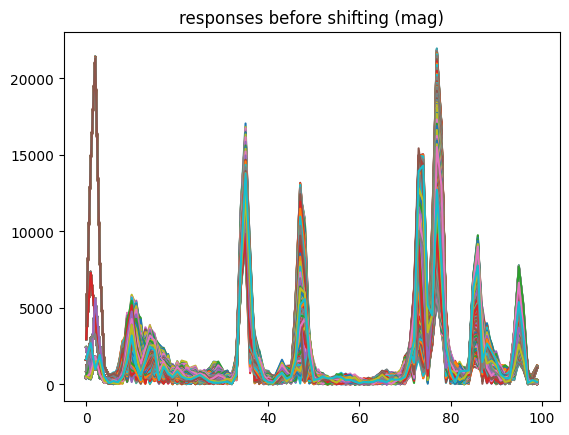

In [ ]:

#compute the window
window = np.reshape(np.hanning(processor.num_range_bins),(processor.num_range_bins,-1))

windowed_signal = window * adc_cube_reshaped

freq_resps = np.fft.fft(windowed_signal,axis=0)

plt.plot(np.abs(freq_resps))
plt.title("responses before shifting (mag)")

Text(0.5, 1.0, 'responses after shifting (avg dB)')

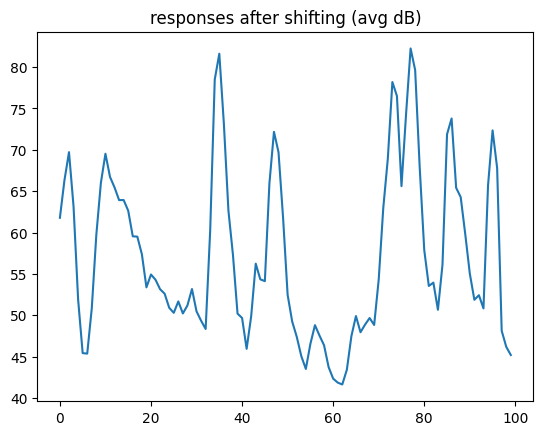

In [ ]:
plt.plot(np.mean(20*np.log10(np.abs(freq_resps)),axis=1))
plt.title("responses after shifting (avg dB)")

Text(0.5, 1.0, 'unshifted response at range 34')

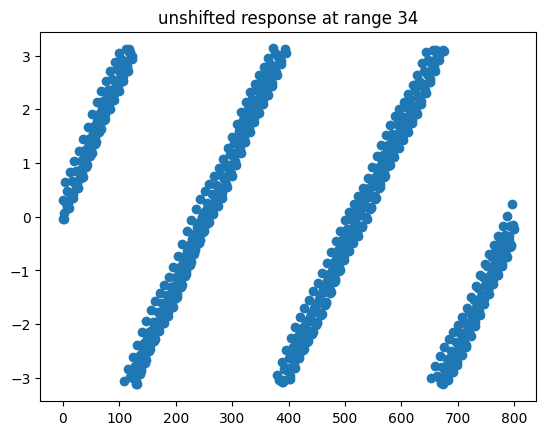

In [ ]:
#range response
peak_idx =34 #34 and 76 have targets

plt.plot(np.angle(freq_resps[peak_idx]),"o")
plt.title("unshifted response at range {}".format(peak_idx))

Text(0.5, 1.0, 'max indicies')

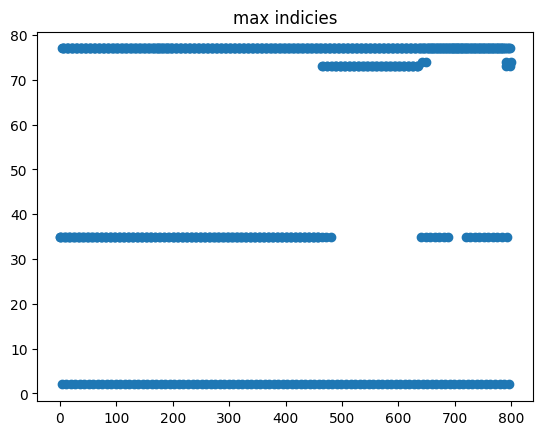

In [ ]:
max_rng_idxs = np.argmax(np.abs(freq_resps),axis=0)
max_idx = np.argmax(freq_resps)

plt.plot(max_rng_idxs,'o')
plt.title("max indicies")


Text(0.5, 1.0, 'shifted response at range 34')

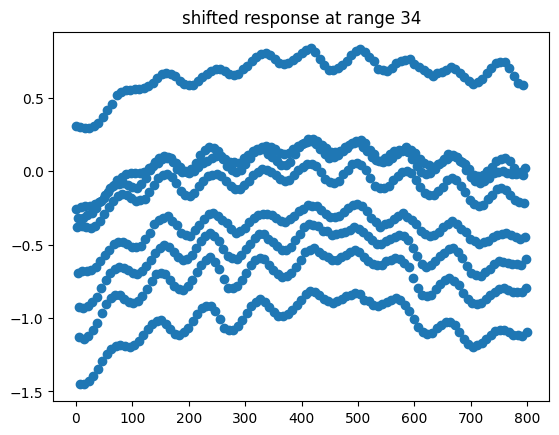

In [ ]:
#shift the freq resps
shifted_resps = np.multiply(freq_resps,shifts)
plt.plot(np.angle(shifted_resps[peak_idx]),"o")
plt.title("Beamformed response at range {}".format(peak_idx))

Text(0.5, 1.0, 'Summed FFT')

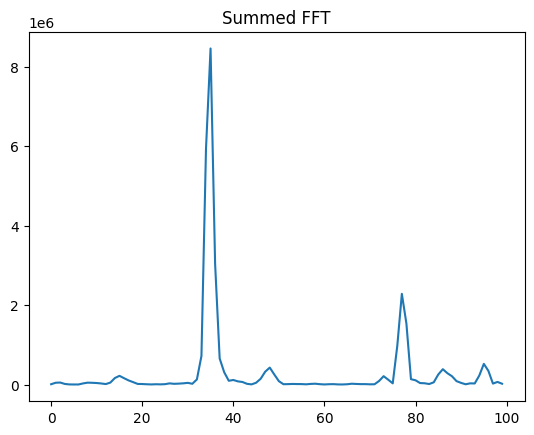

In [79]:
beamformed_resp = np.sum(shifted_resps,axis=1)
plt.plot(np.abs(beamformed_resp))
plt.title("Summed FFT")

  0%|          | 2/1040 [00:00<06:10,  2.80it/s]

100%|██████████| 1040/1040 [02:48<00:00,  6.18it/s]


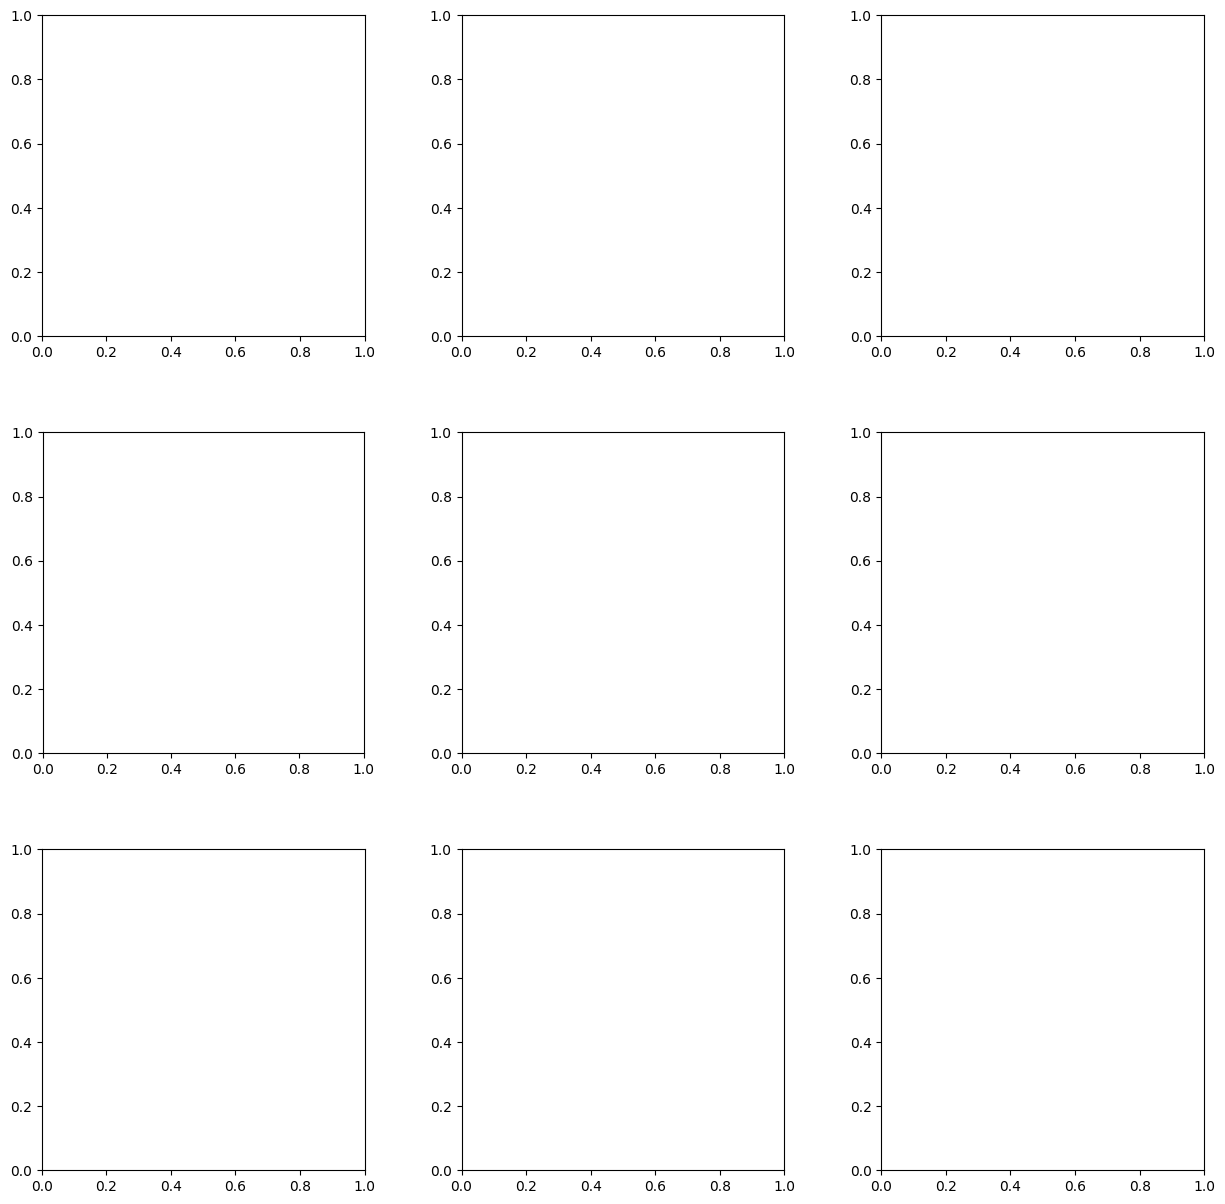

In [30]:
#generate the movie
movie_generator.initialize_figure(nrows=3,ncols=3,figsize=(15,15))

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True,
    lidar_radar_offset_rad=np.deg2rad(180)
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_dB.mp4".format(dataset_name),fps=fps)

In [1]:
cfar = CaCFAR_1D(
    config_manager=cfg_manager,
    num_guard_cells=3,
    num_training_cells=20,
    false_alarm_rate=1e-3,
    resp_border_cells=5,
    mode="full"
)

cfar.plot_cfar(
    signal=resp[:,55,10],
    show=True
)

NameError: name 'CaCFAR_1D' is not defined